In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter



from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

from datetime import datetime

In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
class_names = ['glioma', 'menin', 'tumor']

image_data = np.load('image_data.npy')
image_labels = np.load('image_labels.npy')

# update shape to match PyTorch's format (Examples, Channels, Height, Width)
updated_image_data_temp = np.swapaxes(image_data, 1, 3)
updated_image_data = np.swapaxes(updated_image_data_temp, 2, 3)

print('Orginal shape: ', image_data.shape)
print('New shape: ', updated_image_data.shape)

Orginal shape:  (6056, 256, 256, 3)
New shape:  (6056, 3, 256, 256)


In [4]:
# class for custom dataset needed for pytorch 
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# create train test splits
x_train, x_test, y_train, y_test = train_test_split(updated_image_data, image_labels, test_size=0.2, random_state=12, shuffle=True)

# encode labels numerically
label_encoder = LabelEncoder() 
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

training_set = CustomDataset(x_train, y_train)
test_set = CustomDataset(x_test, y_test)

In [5]:
# code for training on single epoch
def train_single_epoch(epoch_index, tb_writer, dloader, model, optimizer, loss,):
    running_loss_two = 0.0
    total_loss_two = 0.0  # Track total for the entire epoch
    
    for i, data in enumerate(dloader):
        inputs, labels = data
        inputs = inputs.to(mps_device)
        labels = labels.to(mps_device)
        
        # Zero gradients
        optimizer.zero_grad()

        # Make predictions
        outputs = model(inputs)

        # Compute loss and gradients
        loss_two = loss(outputs, labels)
        loss_two.backward()

        # Adjust learning weights
        optimizer.step()

        # Accumulate losses
        batch_loss = loss_two.item()
        running_loss_two += batch_loss
        total_loss_two += batch_loss * inputs.size(0)  # Scale by batch size
        
        # Report every 1000 batches
        if i % 1000 == 999:
            avg_loss_two = running_loss_two / 1000
            print('  batch {} loss: {:.4f}'.format(i + 1, avg_loss_two))
            tb_x = epoch_index * len(dloader) + i + 1
            tb_writer.add_scalar('Loss/train', avg_loss_two, tb_x)
            running_loss_two = 0.0 
    
    # Return average loss for entire epoch
    epoch_loss_two = total_loss_two / len(dloader.dataset)
    return epoch_loss_two

In [6]:
#ResNet-50 Implamentation
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer_res = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

training_size = int(len(training_set) * 0.8)
val_size = len(training_set) - training_size
rand_generator = torch.Generator().manual_seed(13)
training_set, val_set = random_split(training_set, [training_size, val_size], generator=rand_generator)

# Load instance of ResNet50
res_model = models.resnet50(weights='DEFAULT') # defualt weights ResNet50_Weightsd.IMAGENET1K_V2
num_ftrs = res_model.fc.in_features # get number of filters
res_model.to(mps_device) # send to GPU

# set loss function and optimize
res_loss_fn = nn.CrossEntropyLoss()
res_optimizer = torch.optim.Adam(res_model.parameters(), lr = 0.0002)

# great dataloaders
training_loader = DataLoader(training_set, batch_size=10, shuffle=True)
val_loader = DataLoader(val_set, batch_size=10, shuffle=True)

# data holders
train_loss_list_res = []
val_loss_list_res = []
val_accuracy_res = []

EPOCHS = 50
best_vloss_res = 1_000_000.

# main training loop
for epoch_idx in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_idx + 1))

    # data holders for performance metrics
    true_labels_list_res = []
    val_probs_res = []
    predicted_labels_list_res = []

    res_model.train()
    train_loss_res = train_single_epoch(epoch_idx, writer_res, training_loader, res_model, res_optimizer, res_loss_fn)
    train_loss_list_res.append(train_loss_res)
    
    running_vloss_res = 0.0

    res_model.eval()

    with torch.no_grad():
        # val 
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(mps_device)
            vlabels = vlabels.to(mps_device)
            voutputs = res_model(vinputs)
            _, predicted = torch.max(voutputs, 1)
            vloss = res_loss_fn(voutputs, vlabels)
            running_vloss_res += vloss

            vlabels_arr = vlabels.detach().cpu().numpy()
            predicted_arr = predicted.detach().cpu().numpy()
                
            true_labels_list_res.extend(vlabels_arr)
            predicted_labels_list_res.extend(predicted_arr)
            # data for ROC_curve
            probabilities = nn.functional.softmax(voutputs, dim=1)
            probabilities_arr = probabilities.detach().cpu().numpy()
            val_probs_res.extend(probabilities_arr)
        
    val_accuracy_res.append(metrics.accuracy_score(true_labels_list_res, predicted_labels_list_res))            
    
    val_loss_res = vloss

    print(f'Training loss: {train_loss_res} \n'
          f'Validation loss: {val_loss_res}')

    val_loss_list_res.append(val_loss_res)

    writer_res.add_scalars('Training vs. Validation Loss',
                    {'Training' : train_loss_res, 'Validation' : val_loss_res},
                    epoch_idx + 1)
    
    writer_res.flush()
    if vloss < 2e-5:
        print(f"STOPPED REACH - Final Loss: {vloss}")
        best_vloss_res = val_loss_res
        model_path = 'ResNet_{}_{}'.format(timestamp, epoch_idx)
        torch.save(res_model.state_dict(), model_path)
        break
    if val_loss_res < best_vloss_res:
        best_vloss_res = val_loss_res
        model_path = 'model_one_{}_{}'.format(timestamp, epoch_idx)
        torch.save(res_model.state_dict(), model_path)


EPOCH 1:
Training loss: 0.4032931042480613 
Validation loss: 0.1488717496395111
EPOCH 2:
Training loss: 0.07546455501638834 
Validation loss: 0.01348440907895565
EPOCH 3:
Training loss: 0.04807598643876131 
Validation loss: 0.0013288751943036914
EPOCH 4:
Training loss: 0.04696757599142485 
Validation loss: 0.13911442458629608
EPOCH 5:
Training loss: 0.030122322689811323 
Validation loss: 0.38624680042266846
EPOCH 6:
Training loss: 0.023715804621629838 
Validation loss: 0.009141948074102402
EPOCH 7:
Training loss: 0.014039275562951639 
Validation loss: 0.0005610918160527945
EPOCH 8:
Training loss: 0.04227226365078921 
Validation loss: 0.39615288376808167
EPOCH 9:
Training loss: 0.04395164857479563 
Validation loss: 0.00037792965304106474
EPOCH 10:
Training loss: 0.0032270108627515935 
Validation loss: 0.00012551614781841636
EPOCH 11:
Training loss: 0.010741963733148183 
Validation loss: 0.009025698527693748
EPOCH 12:
Training loss: 0.017876647500684597 
Validation loss: 0.00032104196725

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       318
         1.0       1.00      0.99      0.99       318
         2.0       0.99      1.00      1.00       333

    accuracy                           1.00       969
   macro avg       1.00      1.00      1.00       969
weighted avg       1.00      1.00      1.00       969

{0: 0.9999903390043379, 1: 0.9997584751084447, 2: 0.9998819574291272}


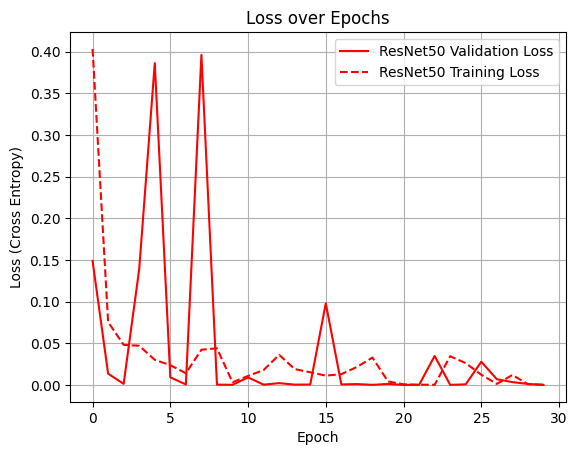

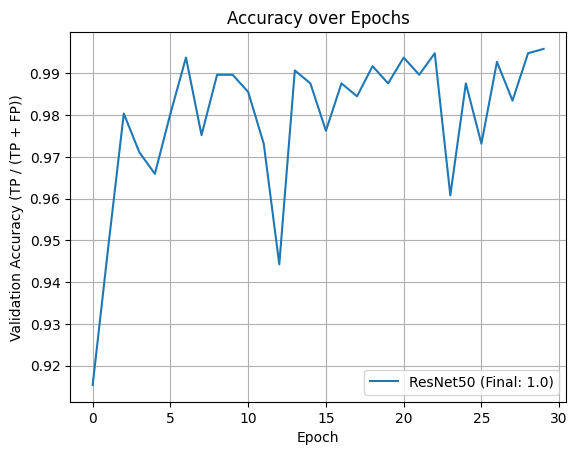

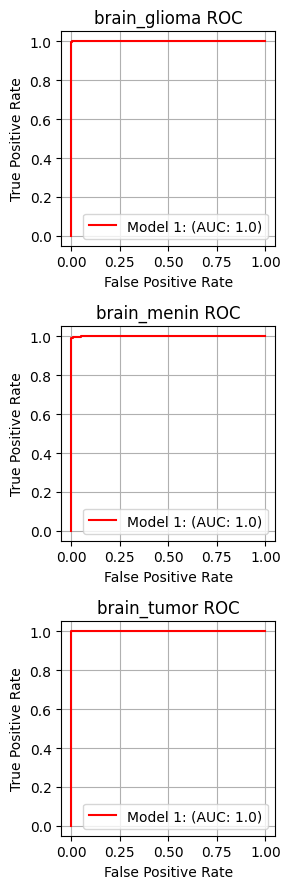

In [ ]:
# Plot Training Metrics
class_report_one = metrics.classification_report(true_labels_list_res, predicted_labels_list_res)
print(class_report_one)

# move loss values from gpu back to cpu
val_losses_res = []
for loss in val_loss_list_res:
    val_losses_res.append(loss.cpu())

# false positive rates dict
fpr_res = dict()

# true positive rates dict
tpr_res = dict()

#  ROC AUCs d
ROC_auc_res = dict()
true_labels_arr = np.array(true_labels_list_res)
val_probs_res = np.array(val_probs_res)

#ROC calculations
for class_index in range(len(class_names)):
    binary_true_labels_res = (true_labels_arr == class_index)
    class_probabilities_res = val_probs_res[:, class_index]

    fpr_res[class_index], tpr_res[class_index], _ = metrics.roc_curve(binary_true_labels_res, class_probabilities_res) # roc for target class
    ROC_auc_res[class_index] = metrics.roc_auc_score(binary_true_labels_res, class_probabilities_res)

ordered_label_keys = label_encoder.inverse_transform([0, 1, 2])
print(ROC_auc_res)
epoch__count_array = (np.arange(epoch_idx + 1)) # create array for epochs to plot w/

#Plotting!
plt.figure(1, clear=True)

plt.plot(epoch__count_array, val_losses_res, color='red', label='ResNet50 Validation Loss')
plt.plot(epoch__count_array, train_loss_list_res, color='red', linestyle='--', label='ResNet50 Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.title('Loss over Epochs')
plt.grid(True)
plt.show()

plt.figure(2, clear=True)
plt.plot(epoch__count_array, val_accuracy_res, label=f'ResNet50 (Final: {round(val_accuracy_res[-1], 2)})')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (TP / (TP + FP))')
plt.legend()
plt.title('Accuracy over Epochs')
plt.grid(True)
plt.show()

plt.figure(3, clear=True, figsize=(3, 9))

for i in range(len(fpr_res)):
    plt.subplot(3, 1, (i+1))
    plt.plot(fpr_res[i], tpr_res[i], color='Red', label=f'Model 1: (AUC: {round(ROC_auc_res[i], 2)})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title(ordered_label_keys[i] + ' ROC')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Test ResNet
test_true_labels_res = []
test_predicted_res = []
test_probs_res = []
test_accuracy_res = []
test_loss_res = []

test_loader = DataLoader(test_set, batch_size=10, shuffle=True)


print('Running Test')
res_model.eval()
with torch.no_grad():
    # val 
    for i, tdata in enumerate(test_loader):
        tinputs, tlabels = tdata
        tinputs = tinputs.to(mps_device)
        tlabels = tlabels.to(mps_device)
        toutputs = res_model(tinputs)
        _, predicted = torch.max(toutputs, 1)
        tloss = res_loss_fn(toutputs, tlabels)
        running_vloss_res += tloss

        tlabels_arr = tlabels.detach().cpu().numpy()
        predicted_arr = predicted.detach().cpu().numpy()
                
        test_true_labels_res.extend(tlabels_arr)
        test_predicted_res.extend(predicted_arr)
        # data for ROC_curve
        probabilities = nn.functional.softmax(toutputs, dim=1)
        probabilities_arr = probabilities.detach().cpu().numpy()
        test_probs_res.extend(probabilities_arr)

    test_loss_res.append(tloss)
    test_accuracy_res.append(metrics.accuracy_score(test_true_labels_res, test_predicted_res))  

print("Test Complete!")
class_report_test = metrics.classification_report(test_true_labels_res, test_predicted_res)
print(class_report_test)


Running Test
Test Complete!
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       371
         1.0       0.99      0.99      0.99       411
         2.0       0.99      0.99      0.99       430

    accuracy                           0.99      1212
   macro avg       0.99      0.99      0.99      1212
weighted avg       0.99      0.99      0.99      1212



{0: 0.9999230796350127, 1: 0.9994684260246468, 2: 0.9995955510616784}


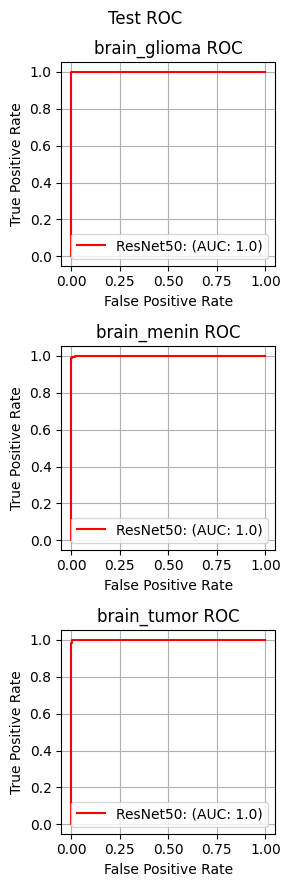

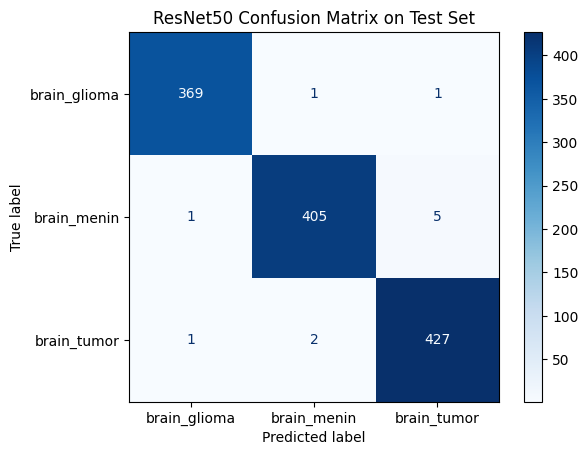

In [19]:
# Plot Test ROC

# false positive rates dict
fpr_res = dict()
# true positive rates dict
tpr_res = dict()

#  ROC AUCs d
ROC_auc_res = dict()

test_probs_res = np.array(test_probs_res)
test_true_labels_res = np.array(test_true_labels_res)

#ROC calculations
for class_index in range(len(class_names)):
    binary_true_labels_res = (test_true_labels_res == class_index)
    class_probabilities_res = test_probs_res[:, class_index]

    fpr_res[class_index], tpr_res[class_index], _ = metrics.roc_curve(binary_true_labels_res, class_probabilities_res) # roc for target class
    ROC_auc_res[class_index] = metrics.roc_auc_score(binary_true_labels_res, class_probabilities_res)

ordered_label_keys = label_encoder.inverse_transform([0, 1, 2])
print(ROC_auc_res)

#Plotting!
plt.figure(1, clear=True, figsize=(3, 9))

for i in range(len(fpr_res)):
    plt.subplot(3, 1, (i+1))
    plt.plot(fpr_res[i], tpr_res[i], color='Red', label=f'ResNet50: (AUC: {round(ROC_auc_res[i], 2)})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title(ordered_label_keys[i] + ' ROC')
    plt.grid(True)

plt.suptitle('Test ROC')
plt.tight_layout()
plt.show()

res_cm = confusion_matrix(test_true_labels_res, test_predicted_res)
disp = ConfusionMatrixDisplay(confusion_matrix=res_cm, display_labels=ordered_label_keys)
disp.plot(cmap=plt.cm.Blues)
plt.title('ResNet50 Confusion Matrix on Test Set')
plt.show()